In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
import apache_log_parser
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
import datetime
from typing import List
import itertools
import datetime


```
influx auth create --org nnao45 --all-access
```

In [2]:
# InfluxDBサーバーのIPアドレスとポート
url = "http://localhost:8086"
# 対象organization
org = "nnao45"
# 対象bucket
bucket = "lab"
# 発行したToken
token = "a5MLHcVrgLgeemWgvTnvNwx83ay4at6l9mmEjB8Zm8KxTr5VHYto-qYMyizBQ0tsORqdaxt3LK2xs1IjCnE6vw=="

In [3]:
client = InfluxDBClient(url=url, token=token, org=org)
 
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [88]:
p = Point("my_measurement").tag("location", "Prague").field("temperature", 25.3)
write_api.write(bucket=bucket, record=p)

In [13]:
tables = query_api.query('from(bucket:"' + bucket + '") |> range(start: -10m)')


In [14]:
for table in tables:
    print(table)
    for row in table.records:
        print (row.values)

FluxTable() columns: 9, records: 1
{'result': '_result', 'table': 0, '_start': datetime.datetime(2022, 5, 14, 1, 31, 16, 64932, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2022, 5, 14, 1, 41, 16, 64932, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2022, 5, 14, 1, 41, 13, 275824, tzinfo=datetime.timezone.utc), '_value': 25.3, '_field': 'temperature', '_measurement': 'my_measurement', 'location': 'Prague'}


In [134]:
def fetch_gatling_records(experiment: str, start_at: datetime.datetime, end_at: datetime.datetime):
    tables: List[FluxTable] = query_api.query((
        'from(bucket: "' + bucket + '")' +
        ' |> range(start: ' + start_at.isoformat() + 'Z, stop: ' + end_at.isoformat() + 'Z)' +
        ' |> filter(fn: (r) => r["_measurement"] == "gatlingLog")' +
        ' |> filter(fn: (r) => r["_field"] == "status")' +
        ' |> filter(fn: (r) => r["experiment"] == "' + experiment + '")' +
        ' |> truncateTimeColumn(unit: 1s)' +
        ' |> group(columns: ["_time"])' +
        ' |> count()' +
        ' |> yield(name: "counts")'
    ))
    return [[{"timestamp": row.values["_time"], "count": row.values["_value"]} for row in table.records][0] for table in tables]

gatling_results = fetch_gatling_records("exp-20220514-001406", datetime.datetime(2022, 5, 14, 0, 14), datetime.datetime(2022, 5, 14, 0, 15))

In [92]:
gatling_results

[{'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 5, tzinfo=datetime.timezone.utc),
  'count': 6},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 6, tzinfo=datetime.timezone.utc),
  'count': 6},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 7, tzinfo=datetime.timezone.utc),
  'count': 6},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 8, tzinfo=datetime.timezone.utc),
  'count': 7},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 9, tzinfo=datetime.timezone.utc),
  'count': 7},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 10, tzinfo=datetime.timezone.utc),
  'count': 8},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 11, tzinfo=datetime.timezone.utc),
  'count': 7},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 12, tzinfo=datetime.timezone.utc),
  'count': 9},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 13, tzinfo=datetime.timezone.utc),
  'count': 9},
 {'timestamp': datetime.datetime(2022, 5, 14, 0, 14, 14, tzinfo=datetime.timez

In [113]:
def fetch_top_records(measurement: str, tag: str, start_at: datetime.datetime, end_at: datetime.datetime):
    tables: List[FluxTable] = query_api.query((
        'cpu =' +
        ' from(bucket: "' + bucket + '")' +
        ' |> range(start: time(v: "' + start_at.isoformat() + 'Z"), stop: time(v: "' + end_at.isoformat() + 'Z"))' +
        ' |> filter(fn: (r) => r["_measurement"] == "' + measurement + '")' +
        ' |> filter(fn: (r) => r["_field"] == "cpu")' +
        # ' |> aggregateWindow(every: 1s, fn: max)' +
        # ' |> fill(usePrevious: true)' +
        ' ' +
        'mem =' +
        ' from(bucket: "' + bucket + '")' +
        ' |> range(start: time(v: "' + start_at.isoformat() + 'Z"), stop: time(v: "' + end_at.isoformat() + 'Z"))' +
        ' |> filter(fn: (r) => r["_measurement"] == "' + measurement + '")' +
        ' |> filter(fn: (r) => r["_field"] == "mem")' +
        # ' |> aggregateWindow(every: 1s, fn: max)' +
        # ' |> fill(usePrevious: true)' +
        ' ' +
        'join(tables: {t1: cpu, t2: mem}, on: ["_time", "' + tag + '"], method: "inner")' +
        ' |> keep(columns: ["_time", "' + tag +'", "_field_t1", "_field_t2", "_value_t1", "_value_t2"])'
        
    ))
    return [[row.values for row in table.records] for table in tables]

pod_top_results = fetch_top_records("kubeTopPod", "pod", datetime.datetime(2022, 5, 14, 0, 13), datetime.datetime(2022, 5, 14, 0, 16))
node_top_results = fetch_top_records("kubeTopNode", "node", datetime.datetime(2022, 5, 14, 0, 13), datetime.datetime(2022, 5, 14, 0, 16))

In [123]:
pod_top_results

[[{'result': '_result',
   'table': 0,
   '_field_t1': 'cpu',
   '_field_t2': 'mem',
   '_time': datetime.datetime(2022, 5, 14, 0, 13, 31, tzinfo=datetime.timezone.utc),
   '_value_t1': 1.0,
   '_value_t2': 238.0,
   'pod': 'query-api-app-66c6645d96-gdzsk'},
  {'result': '_result',
   'table': 0,
   '_field_t1': 'cpu',
   '_field_t2': 'mem',
   '_time': datetime.datetime(2022, 5, 14, 0, 13, 32, tzinfo=datetime.timezone.utc),
   '_value_t1': 1.0,
   '_value_t2': 238.0,
   'pod': 'query-api-app-66c6645d96-gdzsk'},
  {'result': '_result',
   'table': 0,
   '_field_t1': 'cpu',
   '_field_t2': 'mem',
   '_time': datetime.datetime(2022, 5, 14, 0, 13, 33, tzinfo=datetime.timezone.utc),
   '_value_t1': 1.0,
   '_value_t2': 238.0,
   'pod': 'query-api-app-66c6645d96-gdzsk'},
  {'result': '_result',
   'table': 0,
   '_field_t1': 'cpu',
   '_field_t2': 'mem',
   '_time': datetime.datetime(2022, 5, 14, 0, 13, 34, tzinfo=datetime.timezone.utc),
   '_value_t1': 1.0,
   '_value_t2': 238.0,
   'pod':

In [78]:
node_top_results

[{'result': '_result',
  'table': 0,
  '_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 13, 31, tzinfo=datetime.timezone.utc),
  '_value_t1': 68.0,
  '_value_t2': 1401.0,
  'node': 'gke-primary-jaist-la-primary-jaist-la-3a564921-1h7w'},
 {'result': '_result',
  'table': 0,
  '_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 13, 32, tzinfo=datetime.timezone.utc),
  '_value_t1': 68.0,
  '_value_t2': 1401.0,
  'node': 'gke-primary-jaist-la-primary-jaist-la-3a564921-1h7w'},
 {'result': '_result',
  'table': 0,
  '_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 13, 33, tzinfo=datetime.timezone.utc),
  '_value_t1': 68.0,
  '_value_t2': 1401.0,
  'node': 'gke-primary-jaist-la-primary-jaist-la-3a564921-1h7w'},
 {'result': '_result',
  'table': 0,
  '_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 13, 34, tzinfo=datetime.timezone.utc),
  '_value_

In [5]:
def compute_enet(x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

In [4]:
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

In [107]:
enet = compute_enet(np.array([g["timestamp"].timestamp() for g in gatling_results]).reshape(-1, 1), np.array([g["count"] for g in gatling_results]).reshape(-1, 1))
target_y_pred = enet.predict(np.array([gatling_results[len(gatling_results)-1]["timestamp"].timestamp() + 1]).reshape(-1, 1))
target_y_pred

array([23.94037807])

In [97]:
RangeEn_B([g["count"] for g in gatling_results])

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_15507/186529201.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


0.08882289266607862

In [6]:
def fetch_gatling_records(start_at: datetime.datetime, end_at: datetime.datetime):
    tables: List[FluxTable] = query_api.query((
        'from(bucket: "' + bucket + '")' +
        ' |> range(start: ' + start_at.isoformat() + 'Z, stop: ' + end_at.isoformat() + 'Z)' +
        ' |> filter(fn: (r) => r["_measurement"] == "gatlingLog")' +
        ' |> filter(fn: (r) => r["_field"] == "status")' +
        ' |> truncateTimeColumn(unit: 1s)' +
        ' |> group(columns: ["_time"])' +
        ' |> count()' +
        ' |> yield(name: "counts")'
    ))
    return [[{"timestamp": row.values["_time"], "count": row.values["_value"]} for row in table.records][0] for table in tables]

def fetch_top_records(measurement: str, tag: str, start_at: datetime.datetime, end_at: datetime.datetime):
    tables: List[FluxTable] = query_api.query((
        'cpu =' +
        ' from(bucket: "' + bucket + '")' +
        ' |> range(start: time(v: "' + start_at.isoformat() + 'Z"), stop: time(v: "' + end_at.isoformat() + 'Z"))' +
        ' |> filter(fn: (r) => r["_measurement"] == "' + measurement + '")' +
        ' |> filter(fn: (r) => r["_field"] == "cpu")' +
        ' ' +
        'mem =' +
        ' from(bucket: "' + bucket + '")' +
        ' |> range(start: time(v: "' + start_at.isoformat() + 'Z"), stop: time(v: "' + end_at.isoformat() + 'Z"))' +
        ' |> filter(fn: (r) => r["_measurement"] == "' + measurement + '")' +
        ' |> filter(fn: (r) => r["_field"] == "mem")' +
        ' ' +
        'join(tables: {t1: cpu, t2: mem}, on: ["_time", "' + tag + '"], method: "inner")' +
        ' |> keep(columns: ["_time", "' + tag +'", "_field_t1", "_field_t2", "_value_t1", "_value_t2"])'
        
    ))
    return [[row.values for row in table.records] for table in tables]

def compute_enet(x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def np_reshape(src):
    return np.array(src).reshape(-1, 1)

def predict(now: datetime.datetime):

    target_end_at = now + datetime.timedelta(seconds=-1)
    target_start_at = target_end_at + datetime.timedelta(seconds=-299)

    gatling_results = fetch_gatling_records(target_start_at, target_end_at)
    pod_top_results = fetch_top_records("kubeTopPod", "pod", target_start_at, target_end_at)
    node_top_results = fetch_top_records("kubeTopNode", "node", target_start_at, target_end_at)

    # debug
    pprint(gatling_results[0])
    pprint(pod_top_results[0])
    pprint(node_top_results[0])

    request_enet = compute_enet(np_reshape([g["timestamp"].timestamp() for g in gatling_results]), np_reshape([g["count"] for g in gatling_results]))
    request_y_pred = request_enet.predict(np_reshape([gatling_results[len(gatling_results)-1]["timestamp"].timestamp() + 30]))
    request_range_entropy = RangeEn_B([g["count"] for g in gatling_results])
    pprint(request_y_pred)
    pprint(request_range_entropy)
    

predict(datetime.datetime(2022, 5, 14, 0, 20, 0))

{'count': 24,
 'timestamp': datetime.datetime(2022, 5, 14, 0, 15, tzinfo=datetime.timezone.utc)}
[{'_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 15, 1, tzinfo=datetime.timezone.utc),
  '_value_t1': 4.0,
  '_value_t2': 238.0,
  'pod': 'query-api-app-66c6645d96-gdzsk',
  'result': '_result',
  'table': 0},
 {'_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 15, 2, tzinfo=datetime.timezone.utc),
  '_value_t1': 4.0,
  '_value_t2': 238.0,
  'pod': 'query-api-app-66c6645d96-gdzsk',
  'result': '_result',
  'table': 0},
 {'_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 15, 3, tzinfo=datetime.timezone.utc),
  '_value_t1': 4.0,
  '_value_t2': 238.0,
  'pod': 'query-api-app-66c6645d96-gdzsk',
  'result': '_result',
  'table': 0},
 {'_field_t1': 'cpu',
  '_field_t2': 'mem',
  '_time': datetime.datetime(2022, 5, 14, 0, 15, 4, tzinfo=datetime.timezone.utc),
  '_value_t1': 4.0,
  '_va

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/186529201.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


In [135]:
gatling_results = fetch_gatling_records("exp-20220514-001406", datetime.datetime(2022, 5, 14, 0, 15), datetime.datetime(2022, 5, 14, 0, 20))

In [7]:
pod_top_results = fetch_top_records("kubeTopPod", "pod", datetime.datetime(2022, 5, 16, 12, 33, 0), datetime.datetime(2022, 5, 16, 13, 33, 0))

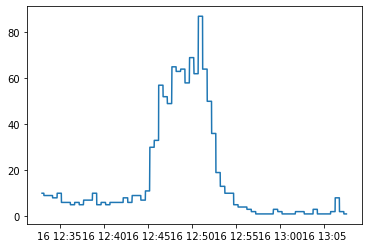

In [8]:
pod_top_results_0 = pod_top_results[0]
pod_top_results_0_x = [top["_time"] for top in pod_top_results_0]
pod_top_results_0_y = [top["_value_t1"] for top in pod_top_results_0]
plt.plot(pod_top_results_0_x,pod_top_results_0_y )

In [143]:
pod_top_results_0_x[1], pod_top_results_0_x[len(pod_top_results_0_x)-1]

(datetime.datetime(2022, 5, 16, 12, 33, 1, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 5, 16, 13, 7, 29, tzinfo=datetime.timezone.utc))

In [144]:
len(pod_top_results_0_x)

1591

In [9]:
def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 300, incr = 30):
    y_pred = pd.DataFrame([])
    counter = batch_size
    while len(x) > counter:
        try:
            x_train = x[counter-batch_size:counter]
            y_train = y[counter-batch_size:counter]
            x_test = x[counter:counter+incr].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return y_pred

In [11]:
pred_pod_top_results_0_y = enet_loop(np.array([x.timestamp() for x in pod_top_results_0_x]).reshape(-1, 1), np.array(pod_top_results_0_y).reshape(-1, 1))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecat

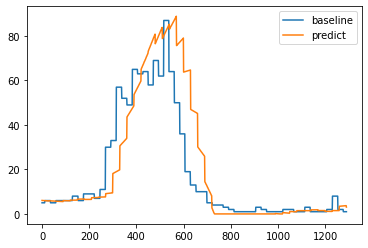

In [31]:
plt.plot(pod_top_results_0_y[300:], label='baseline')
plt.plot(pred_pod_top_results_0_y.applymap(lambda x: 0 if x < 0 else x), label='predict')
plt.legend()

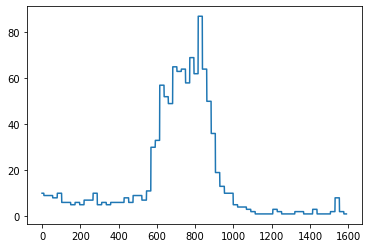

In [176]:
plt.plot(pod_top_results_0_y[:300]+pod_top_results_0_y[300:], label='baseline')


In [26]:
len(pred_pod_top_results_0_y), len(pod_top_results_0_y[300:])

(1291, 1291)

In [170]:
a = [x + np.random.random_integers(0.1, 1) for x in [10] * 1000]
b = [x*10 for x in range(100)[1:]]
c = [x + np.random.random_integers(10, 20) for x in [1000, 900, 880, 900, 1000] * 100]
d = [x*10+1000 for x in range(100)[1:]]
e = [x + np.random.random_integers(10, 20) for x in [2000, 1900, 1880, 1900, 2000] * 100]
f = list(reversed(d))
g = list(reversed(b))
baseline = a+b+c+d+e+f+g+a

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/2340971581.py:1: DeprecationWarning: This function is deprecated. Please call randint(0.1, 1 + 1) instead
  a = [x + np.random.random_integers(0.1, 1) for x in [10] * 1000]
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/2340971581.py:3: DeprecationWarning: This function is deprecated. Please call randint(10, 20 + 1) instead
  c = [x + np.random.random_integers(10, 20) for x in [1000, 900, 880, 900, 1000] * 100]
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/2340971581.py:5: DeprecationWarning: This function is deprecated. Please call randint(10, 20 + 1) instead
  e = [x + np.random.random_integers(10, 20) for x in [2000, 1900, 1880, 1900, 2000] * 100]


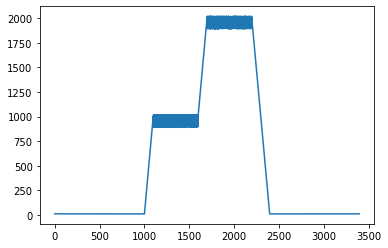

In [171]:
plt.plot(baseline)

In [158]:
pred_test_y = enet_loop(np_reshape(list(range(len(baseline)))), np_reshape(baseline))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecat

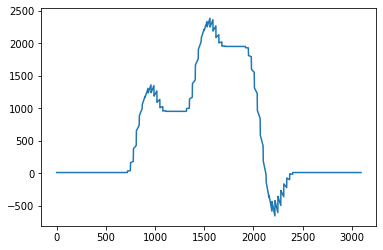

In [159]:
plt.plot(pred_test_y)

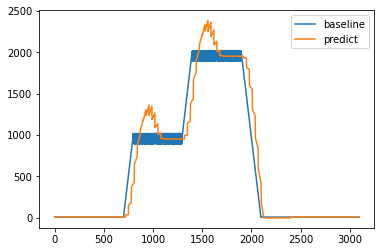

In [160]:
plt.plot(baseline[300:], label='baseline')
plt.plot(pred_test_y.applymap(lambda x: 0 if x < 0 else x), label='predict')
plt.legend()

In [161]:
def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [168]:
RangeEn_B(np.array(baseline[0:300]))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/186529201.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


0.6701677565420638

In [163]:
calc_rangenb_y = rangenb_loop(baseline)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/186529201.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


In [164]:
calc_rangenb_y

[0.6930585712824934,
 0.6930585712824934,
 0.6930585712824932,
 0.6947046621891624,
 0.6941604680245602,
 0.6952599733579773,
 0.6947100695772791,
 0.6937066487405203,
 0.692147842699686,
 0.6914136914214792,
 0.692138778350224,
 0.6926851766881963,
 0.6918674037109082,
 0.6915926784003656,
 0.6919531461805308,
 0.6924054796810654,
 0.6920421735916923,
 0.6919495920992588,
 0.6924926276814327,
 0.6915867473928105,
 0.6924941061339489,
 0.6928572802799412,
 0.6920421735916925,
 0.6915867473928096,
 0.6919468358204548,
 0.6928533720080028,
 0.6934022889227353,
 0.6934075609311883,
 0.693775228822546,
 0.6937752288225459,
 0.6937752288225457,
 0.6937752288225459,
 0.693775228822546,
 0.6937752288225463,
 0.693775228822546,
 0.693775228822546,
 0.6932287309493961,
 0.6924980565483484,
 0.6921310638355339,
 0.6912227222576713,
 0.6912214125934611,
 0.6914924765210296,
 0.692126799708274,
 0.6923102699450703,
 0.6912227222576698,
 0.691403308313641,
 0.6904980851143236,
 0.6914033083136408,


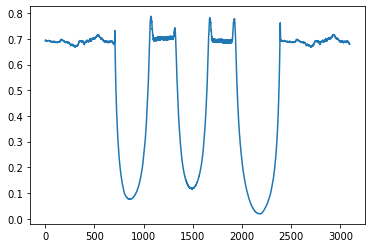

In [165]:
plt.plot(calc_rangenb_y)

In [169]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [172]:
calc_samplen_y = sampen_loop(baseline)

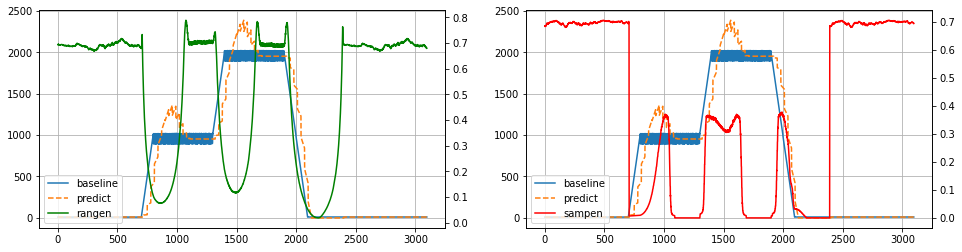

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ln1 = axes[0].plot(baseline[300:],label='baseline')
ln1_2 = axes[0].plot(pred_test_y.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

ax1 = axes[0].twinx()
ln2 = ax1.plot(calc_rangenb_y, color='green', label="rangen")

h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes[0].legend(h1+h2, l1+l2, loc='lower left')

axes[0].grid(True)

rn1 = axes[1].plot(baseline[300:],label='baseline')
rn1_2 = axes[1].plot(pred_test_y.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

ax2 = axes[1].twinx()
rn2 = ax2.plot(calc_samplen_y, color='red', label="sampen")

h3, l3 = axes[1].get_legend_handles_labels()
h4, l4 = ax2.get_legend_handles_labels()
axes[1].legend(h3+h4, l3+l4, loc='lower left')

axes[1].grid(True)

In [177]:
baseline_2 = pod_top_results_0_y[:300]+pod_top_results_0_y[300:]

In [178]:
pred_test_y_2 = enet_loop(np_reshape(list(range(len(baseline_2)))), np_reshape(baseline_2))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecat

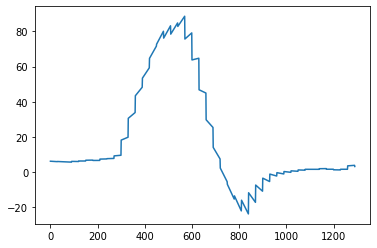

In [179]:
plt.plot(pred_test_y_2)

In [180]:
calc_rangenb_y_2 = rangenb_loop(baseline_2)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/186529201.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


In [181]:
calc_samplen_y_2 = sampen_loop(baseline_2)

In [183]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy.spatial.distance import pdist
from typing import List
import sys
import math

def disten(ser: List[float], m: int = 2, tau: int = 8 , B: int = 512) -> float:
    """
    @param ser: time-series (vector in a column)
    @param m: embedding dimension (scalar)
    @param tau: time delay (scalar)
    @param B: bin number for histogram (scalar)
    """

    # rescaling
    rescaled = [y / (max(ser) - min(ser) + sys.float_info.epsilon) for y in [x - min(ser) for x in ser]]

    # distance matrix
    N = len(rescaled) - (m - 1) * tau
    if N < 0:
        raise(f"ser is too short: {len(ser)}")
    ind = hankel(np.arange(1, N+1), np.arange(N, len(rescaled)+1))
    rnt = [[rescaled[z-1] for z in y] for y in [x[::tau] for x in ind]]
    dv = pdist(rnt, 'chebychev')

    # esimating probability density by histogram
    num = pd.cut(dv, np.linspace(0, 1, B), include_lowest=True).value_counts().to_numpy()
    freq = [x / num.sum() for x in num]

    # disten calculation
    prepared = [math.log2(y) for y in [x + sys.float_info.epsilon for x in freq]]
    return -sum([x * y for (x, y) in zip(prepared, freq)]) / math.log2(B)

In [184]:
def disten_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [disten(ser[index:index+batch_size]) for index in range(len(ser[batch_size:]))]

In [185]:
calc_disten_y_2 = disten_loop(baseline_2)

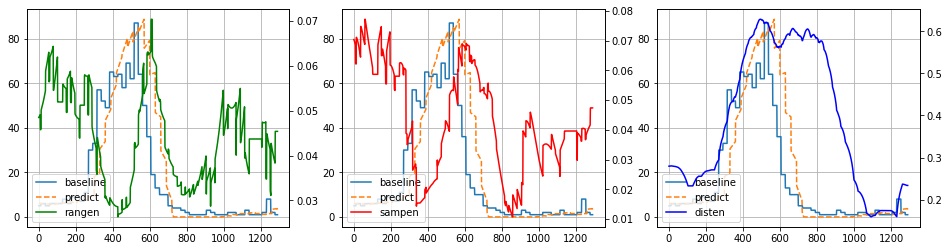

In [187]:
x2_fig, x2_axes = plt.subplots(1, 3, figsize=(16, 4))
x2_ln1 = x2_axes[0].plot(baseline_2[300:],label='baseline')
x2_ln1_2 = x2_axes[0].plot(pred_test_y_2.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

x2_ax1 = x2_axes[0].twinx()
x2_ln2 = x2_ax1.plot(calc_rangenb_y_2, color='green', label="rangen")

x2_h1, x2_l1 = x2_axes[0].get_legend_handles_labels()
x2_h2, x2_l2 = x2_ax1.get_legend_handles_labels()
x2_axes[0].legend(x2_h1+x2_h2, x2_l1+x2_l2, loc='lower left')

x2_axes[0].grid(True)

x2_rn1 = x2_axes[1].plot(baseline_2[300:],label='baseline')
x2_rn1_2 = x2_axes[1].plot(pred_test_y_2.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

x2_ax2 = x2_axes[1].twinx()
x2_rn2 = x2_ax2.plot(calc_samplen_y_2, color='red', label="sampen")

x2_h3, x2_l3 = x2_axes[1].get_legend_handles_labels()
x2_h4, x2_l4 = x2_ax2.get_legend_handles_labels()
x2_axes[1].legend(x2_h3+x2_h4, x2_l3+x2_l4, loc='lower left')

x2_axes[1].grid(True)

x2_sn1 = x2_axes[2].plot(baseline_2[300:],label='baseline')
x2_sn1_2 = x2_axes[2].plot(pred_test_y_2.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

x2_ax3 = x2_axes[2].twinx()
x2_sn2 = x2_ax3.plot(calc_disten_y_2, color='blue', label="disten")

x2_h5, x2_l6 = x2_axes[2].get_legend_handles_labels()
x2_h7, x2_l8 = x2_ax3.get_legend_handles_labels()
x2_axes[2].legend(x2_h5+x2_h7, x2_l6+x2_l8, loc='lower left')

x2_axes[2].grid(True)

In [105]:
list_a = [10] * 1000
list_b = [x*10 for x in range(1500)[1:]]

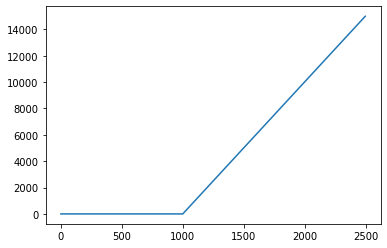

In [106]:
plt.plot(list_a+list_b)

In [108]:
pred_test_y_2 = enet_loop(np_reshape(list(range(len(list_a+list_b)))), np_reshape(list_a+list_b))

/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality

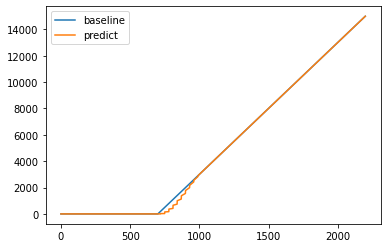

In [109]:
plt.plot((list_a+list_b)[300:], label='baseline')
plt.plot(pred_test_y_2.applymap(lambda x: 0 if x < 0 else x), label='predict')
plt.legend()

In [100]:
x1 = np.linspace(0, 10*np.pi, 1600)
x1 = np.array(x1)
x1train = np.sin(x1)

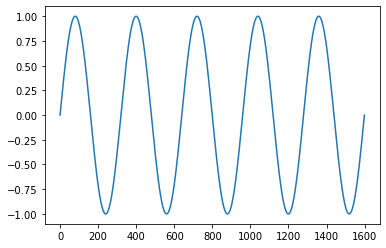

In [101]:
plt.plot(x1train)

In [103]:
pred_test_y_3 = enet_loop(np_reshape(list(range(len(x1train)))), np_reshape(x1train))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_42824/1066909864.py:12: FutureWarning: The frame.append method is deprecat

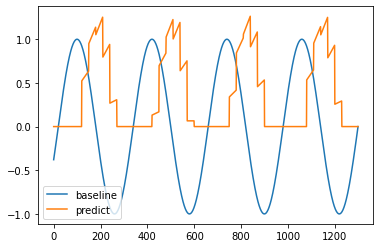

In [104]:
plt.plot(x1train[300:], label='baseline')
plt.plot(pred_test_y_3.applymap(lambda x: 0 if x < 0 else x), label='predict')
plt.legend()